# Komentáře


In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import math
import re

In [3]:
komm = pd.read_csv("komentare.csv", sep='\t')
komm

/tmp/ipykernel_7745/3054238295.py:1: DtypeWarning: Columns (0,1,2,3) have mixed types. Specify dtype option on import or set low_memory=False.
  komm = pd.read_csv("komentare.csv", sep='\t')


,user_id,level,content,created_date
0,57213576,1,vystudovala matematiku a propaguje vědu 🙂........,2022-05-09 15:42:34
1,10489255,0,Tak kde teda vlastně začíná a končí ta rovnopr...,2022-05-09 15:42:25
2,73562771,1,"A mě by ještě zajímalo, co ti hadi žerou, když...",2022-05-09 15:42:14
3,1978370,0,jsem pro mír. Ale naše okresní město Hradec Kr...,2022-05-09 15:42:12
4,775926,1,Naopak maji koule a to se dnes ceni,2022-05-09 15:41:41
...,...,...,...,...
1422715,99972689,1,Perfektní!,2022-04-09 00:00:23
1422716,6781888,1,A které body Minských dohod od roku 2014 to vl...,2022-04-09 00:00:22
1422717,13964387,1,oni si poradí tanky s krabic jsou taky tanky 😄,2022-04-09 00:00:13
1422718,58868252,1,"Vcelku souhlas, ale nevidím, že by někomu nyní...",2022-04-09 00:00:11


## Jaké je rozložení délky komentáře - na počet znaků (nastudovat, co je to histogram) 

In [21]:
cont = komm["content"]
cont.apply(str).apply(len)

0           97
1          308
2          307
3          346
4           35
          ... 
1422715     10
1422716     69
1422717     47
1422718    184
1422719     59
Name: content, Length: 1422720, dtype: int64

## Histogram dne. V kterém časovém období dne píšou lidé nejvíc komentáře?

In [39]:
%%time
histo = komm['created_date'].dropna()
histo = histo.apply(lambda x: datetime.datetime.strptime(str(x), "%Y-%m-%d %H:%M:%S").hour)


CPU times: user 13.4 s, sys: 95.7 ms, total: 13.5 s
Wall time: 13.5 s


In [41]:
%%time
histo = komm['created_date'].dropna()
## bez pretypovani je to znatelne rychlejsi
histo = histo.apply(lambda x: str(x)[str(x).index(' '):str(x).index(' ')+2:1])

CPU times: user 947 ms, sys: 85.3 ms, total: 1.03 s
Wall time: 1.03 s


<AxesSubplot:ylabel='Frequency'>

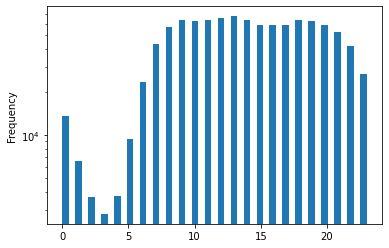

In [85]:
# 24 * 2 - 1 = 47
# pocet mezer je o 1 min nez pocet sloupcu
histo.plot.hist(bins=47, logy=True)

## Jaký je poměr komentářů na první (level=0) a druhé úrovni (level=1)

### Řešení č.1 
- je znatelně rychlejší než regex ale o to je hůř čitelnější

In [42]:
%%time

def tint(x):
    try:
        return int(x)
    except ValueError:
        return -1



l = komm['level']
c1 = 0
c2 = 0
#hodne trapne reseni
for index, value in l.items():
    if tint(value) == 0:
        c1+=1
    elif tint(value) == 1:
        c2+=1

d = math.gcd(c1, c2)  
#print(d)
c1 = int(c1 / d);
c2 = int(c2 / d);
print(f"POMER uroven1:uroven2 {c1}:{c2}")

POMER uroven1:uroven2 424129:707428
CPU times: user 1.08 s, sys: 903 µs, total: 1.08 s
Wall time: 1.08 s


### Řešení č.2
- Využití Regexu

In [43]:
%%time
ll = komm.set_index('level')["user_id"]

l1 = ll.filter(regex=r"^0")
l2 = ll.filter(regex=r"^1")

c1 = l1.count()
c2 = l2.count()

d = math.gcd(c1,c2)

print(f"POMER uroven1:uroven2 {int(c1/d)}:{int(c2/d)}")

POMER uroven1:uroven2 424129:707428
CPU times: user 4.07 s, sys: 262 ms, total: 4.33 s
Wall time: 4.32 s


## Kolik unikátních uživatelů napsalo minulý měsíc komentář?

In [47]:
%%time
today = datetime.date.today()
first = today.replace(day=1)
lastMonth = first - datetime.timedelta(days=1)
yearMonth = lastMonth.strftime("%Y-%m")

last_m = komm.set_index("user_id")["created_date"].dropna()
last_m = last_m.apply(lambda x: str(x)[0:7:1])
reverse = pd.Series(data=last_m.index,index=last_m.values)
reverse.filter(like=yearMonth).drop_duplicates().count()


CPU times: user 1.46 s, sys: 164 ms, total: 1.62 s
Wall time: 1.64 s


70744

## Vypsat prvních 100 nejaktivnějších přispěvatelů.

In [63]:
poleUid = pd.Series(komm.dropna()["user_id"].values)
poleUid.value_counts().head(100).index.tolist()

['1076207',
 '110669851',
 '777223',
 '29255935',
 '15911976',
 '8305572',
 '15200198',
 '9766466',
 '21226504',
 '3091490',
 '7314619',
 '33778487',
 '25862381',
 '27491091',
 '94194026',
 '111227721',
 '9274686',
 '96041897',
 '31535430',
 '109873414',
 '10925447',
 '6691805',
 '12249702',
 '2971285',
 '123606051',
 '102400715',
 '2323135',
 '102790395',
 '6635944',
 '105055592',
 '69408498',
 '19050120',
 '4190557',
 '106685308',
 '96007007',
 '35815564',
 '32434969',
 '63337511',
 '498810',
 '41182835',
 '155883',
 '8845554',
 '6453565',
 '10945340',
 '9238387',
 '20395836',
 '1243315',
 '123512700',
 '17033079',
 '13725160',
 '42991533',
 '8712398',
 '101507519',
 '16420933',
 '13020447',
 '31222131',
 '1035946',
 '92112342',
 '109399360',
 '91228238',
 '5343455',
 '111139861',
 '59902640',
 '126744710',
 '123920360',
 '2801510',
 '11790696',
 '16755127',
 '108948380',
 '104966156',
 '150578',
 '125731119',
 '65104233',
 '13283053',
 '25906314',
 '9664516',
 '109979789',
 '8124766

## Výzva z pokročilejších algoritmů: Pomocí algoritmu tf-idf extrahovat nejrelevantnější/nejvýznamnější slova z každého komentáře.

### Řešení č.1

#### Získat list všech slov

In [18]:
def UnikatniSlova(veta):
    slova = []
    for veta in vety:
        slova.extend(re.sub(r"\W+"," ",str(veta)).split(" "))
    uslova = []
    for slovo in slova:
        if slovo not in uslova:
            uslova.append(slovo)


#### Získat počet komentářu

#### Každé slovo projít každým komentářem